In [ ]:
# ─────────── Imports (only once) ───────────
import os
import pandas as pd
import numpy as np
import ast
from rapidfuzz import process, fuzz
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection  import train_test_split, GridSearchCV
from sklearn.ensemble        import RandomForestRegressor
from sklearn.metrics         import mean_squared_error, r2_score

# ─────────── Load & Drop ───────────
df = pd.read_csv(os.path.join(os.getcwd(), "airbnbListingsData.csv"))
dropping_col = [ 'host_name',
 'host_location',
 'host_about',
 'host_response_rate',
 'host_acceptance_rate',
 'host_total_listings_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'n_host_verifications',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms',
 'calculated_host_listings_count_shared_rooms', 'neighborhood_overview', 'name', 'description']
df.drop(columns=dropping_col, errors='ignore', inplace=True)

# ─────────── Missing Values ───────────
#   object→'Unknown', numeric→mean
for c in df.columns:
    if df[c].dtype == 'object':
        df[c].fillna('Unknown', inplace=True)
    else:
        df[c].fillna(df[c].mean(), inplace=True)

# ─────────── Price & Log-Transform ───────────
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df['log_price'] = np.log1p(df['price'])

# ─────────── Amenities Normalize & Prune ───────────
df['amenities'] = df['amenities'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
standard_amenities = {
    'wifi': ['wifi', 'fast wifi'],
    'tv': ['tv', 'hdtv', 'flat screen'],
    'streaming_services': ['netflix', 'hbo max', 'amazon prime video', 'apple tv', 'chromecast', 'roku'],
    'body_soap': ['body soap', 'bar soap', 'body wash'],
    'shampoo': ['shampoo'],
    'conditioner': ['conditioner'],
    'sound_system': ['sound system', 'bluetooth sound system', 'speaker'],
    'oven': ['oven', 'air fryer'],
    'stove': ['stove', 'gas stove', 'electric stove'],
    'workspace': ['workspace', 'monitor', 'desk', 'office chair'],
    'refrigerator': ['refrigerator', 'fridge', 'mini fridge'],
    'parking': ['parking', 'garage', 'driveway'],
    'children_amenities': ['children', 'books and toys', 'crib', 'baby bath'],
    'gym': ['gym', 'fitness'],
    'pool': ['pool', 'rooftop pool', 'heated pool']
}
def normalize(a):
    a = a.lower()
    for cat, kws in standard_amenities.items():
        match, score, _ = process.extractOne(a, kws, scorer=fuzz.partial_ratio) or (None, 0, None)
        if score > 80:
            return cat
    return None

df['norm_amenities'] = df['amenities'].apply(lambda L: {normalize(a) for a in L if normalize(a)})

# Build binary columns for the 20 most common normalized amenities
all_norms = set().union(*df['norm_amenities'])
amen_df = pd.DataFrame([{n: int(n in norms) for n in all_norms} for norms in df['norm_amenities']])
freq    = amen_df.sum().sort_values(ascending=False)
top20   = freq.index[:20]
amen_df = amen_df[top20]                            # keep just top 20
df['amenity_count'] = amen_df.sum(axis=1)
df = pd.concat([df, amen_df], axis=1)

# ─────────── One-Hot & Boolean Encode ───────────
df = pd.get_dummies(df, columns=['neighbourhood_group_cleansed','room_type'])
bools = df.select_dtypes(include='bool').columns
for b in bools:
    df[b] = LabelEncoder().fit_transform(df[b])

# ─────────── Final Cleanup ───────────
# drop raw columns no longer needed
df.drop(columns=['amenities','norm_amenities','price'], inplace=True)

# ─────────── Train/Test Split & Model ───────────
X = df.drop(columns='log_price')
y = df['log_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1234)



# print("Training RandomForest…")
# rf = RandomForestRegressor(n_estimators=200, random_state=1234)
# rf.fit(X_train, y_train)
# preds = rf.predict(X_test)

# print("RMSE (log):", np.sqrt(mean_squared_error(y_test, preds)))
# print("R² (log):",  r2_score(y_test, preds))

# ────────── Hyperparameter Tuning ──────────
print("Tuning RandomForest…")
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=1234),
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
preds = best_rf.predict(X_test)

print("Best Parameters:", grid_search.best_params_)
print("RMSE (log):", np.sqrt(mean_squared_error(y_test, preds)))
print("R² (log):", r2_score(y_test, preds))


/var/folders/nf/lqj62v5n3pj50v8m9psrn48c0000gp/T/ipykernel_50907/2194453654.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna(df[c].mean(), inplace=True)
/var/folders/nf/lqj62v5n3pj50v8m9psrn48c0000gp/T/ipykernel_50907/2194453654.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

Training RandomForest…
RMSE (log): 0.37431227409534645
R² (log): 0.7092571668892639


ACTUAL VS PREDICTED


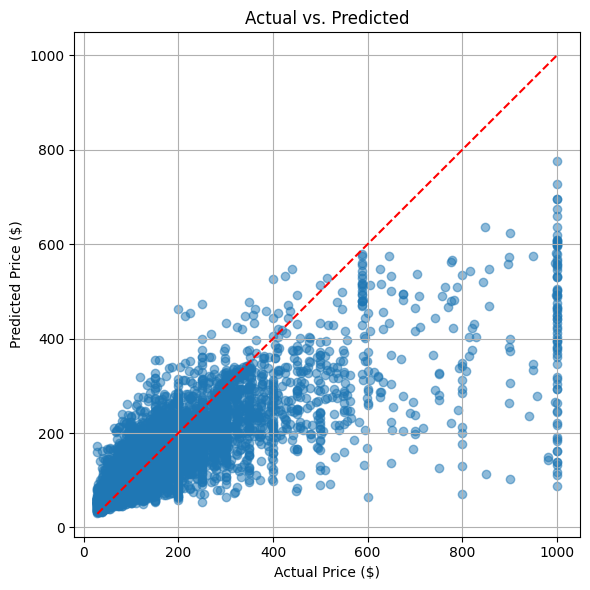

FEATURE IMPORTANCES


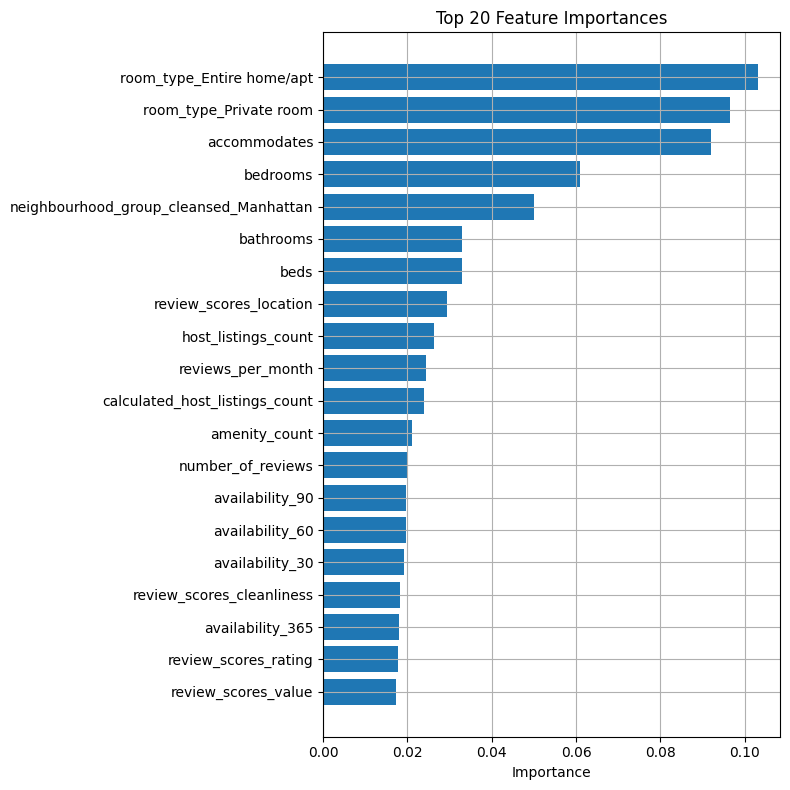

LEARNING CURVE


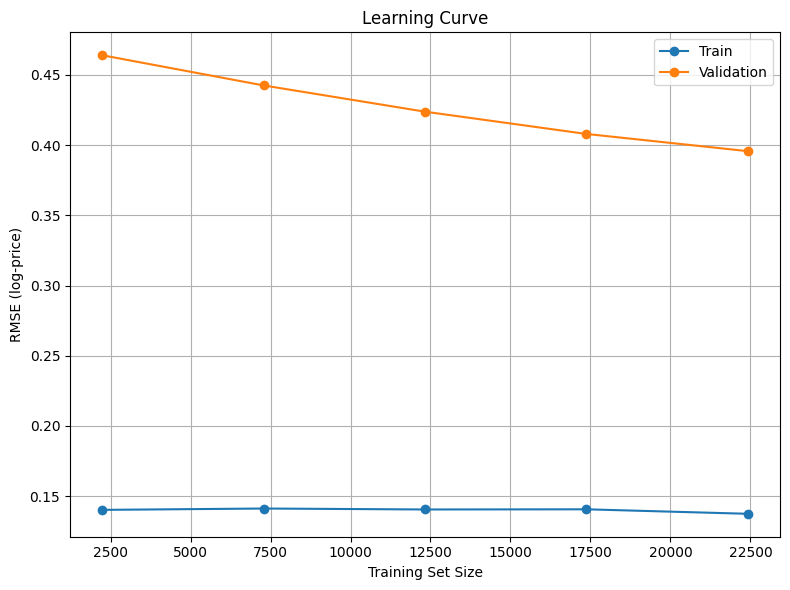

PRICE DISTRIBUTION BEFORE AND AFTER LOG


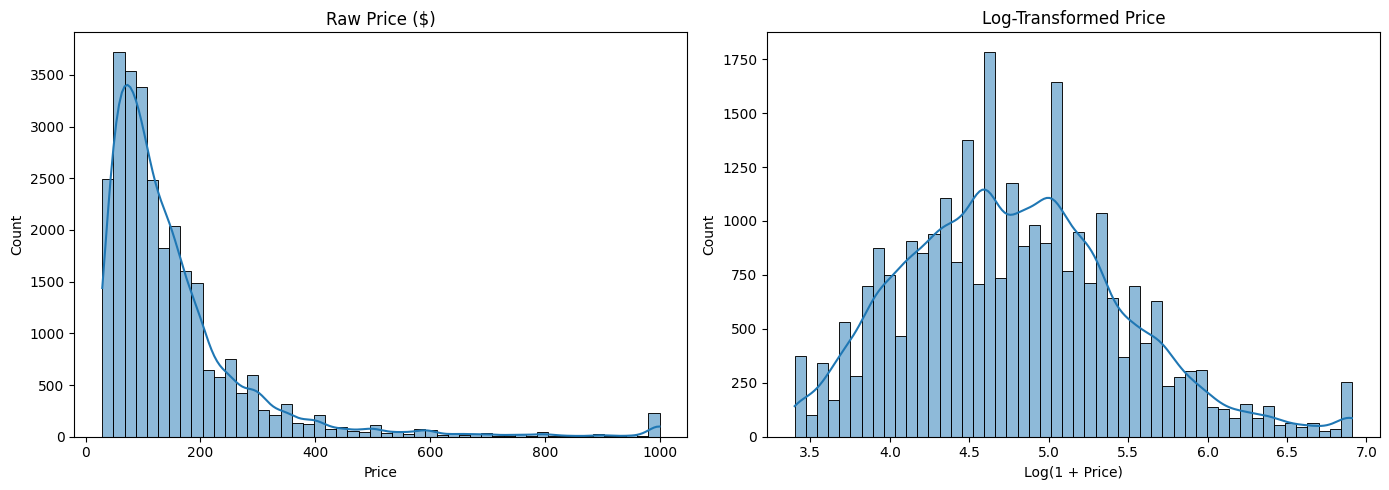

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error, r2_score

### ACTUAL VS PREDICTED ###
print("ACTUAL VS PREDICTED")
best_preds = best_rf.predict(X_test)
plt.figure(figsize=(6, 6))
plt.scatter(np.expm1(y_test), np.expm1(best_preds), alpha=0.5)
plt.plot([np.expm1(y.min()), np.expm1(y.max())], [np.expm1(y.min()), np.expm1(y.max())], 'r--')
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

### FEATURE IMPORTANCES ###
print("FEATURE IMPORTANCES")
importances = best_rf.feature_importances_
idx = np.argsort(importances)[-20:]  # top 20
plt.figure(figsize=(8, 8))
plt.barh(X.columns[idx], importances[idx])
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances")
plt.grid(True)
plt.tight_layout()
plt.show()

### LEARNING CURVE ###
print("LEARNING CURVE")
train_sizes, train_scores, val_scores = learning_curve(
    best_rf, X, y, cv=5, scoring="neg_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1)

train_rmse = np.sqrt(-train_scores.mean(axis=1))
val_rmse = np.sqrt(-val_scores.mean(axis=1))

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_rmse, 'o-', label="Train")
plt.plot(train_sizes, val_rmse, 'o-', label="Validation")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE (log-price)")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### PRICE DISTRIBUTION BEFORE AND AFTER LOG ###
print("PRICE DISTRIBUTION BEFORE AND AFTER LOG")
raw_price = np.expm1(df['log_price'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(raw_price, bins=50, kde=True, ax=axes[0])
axes[0].set_title("Raw Price ($)")
axes[0].set_xlabel("Price")

sns.histplot(df['log_price'], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Log-Transformed Price")
axes[1].set_xlabel("Log(1 + Price)")

plt.tight_layout()
plt.show()
